In [3]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj


In [4]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj


In [5]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

'C:\\Users\\chenr\\OneDrive\\Desktop\\phys-134-proj\\lco_data-20251202-36'

In [6]:
# we need the RA/DEC data from each observation and translate it to pixel coordinates.
import pickle
#load from pickle
with open('merged_data_with_refstarfluxes.pkl', 'rb') as f:
    merged_data = pickle.load(f)
#recall that the keys are the valid observations

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272819 from OBSGEO-[XYZ].
Set OBSGEO-H to     1126.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
# the indices also encode time and coordinate information
# 2025-11-25-h02-m00-s14-ms936-tfn.fits

# COJ - Siding Spring Observatory
coj = "Q63" # is an observatory code
# 31° 16′ 23.88″S
# 149° 4′ 15.6″E

# CPT - (Sutherland) South African Astronomical Observatory
cpt = "K91"
# 32° 22′ 48″S
# 20° 48′ 36″E

#TFN - Teide (Tenerife) Observatory
tfn = "Z31"
# 28º 18′ 00″N
# 16° 30′ 35″W

#LSC - Cerro Tololo Inter-American Observatory
lsc = "W85"
# 30° 10′ 2.64″S
# 70° 48′ 17.28″W

#ELP - McDonald Observatory
elp = "V37"
# 30° 40′ 12″N
# 104° 1′ 12″W

#OGG - Haleakala Observatory
ogg = "T04"
# 20° 42′ 27″N
# 156° 15′ 21.6″W


# Overview: Asteroid Flux Extraction Pipeline

1. earthbound coordinate and time given NASA Horizons API -> RA/DEC Ephemeris
    Extract time from indices and identify observatory
2. Open fits header for that file, use astropy.wcs skycoord_to_pixel to extract -> X,Y Image Pixel Coordinates
    verify with example image using saoimageds9
3. Run 2D gaussian fit on image pixel coordinates -> x_fit, y_fit, sigma_fit
4. Perform aperture photometry to extract flux

next: flux / coeff, do sinusoid model regression

# 1

In [8]:
# 16 psyche SPIKID
SPKID = 20000016

In [9]:
API_URL = "https://ssd.jpl.nasa.gov/api/horizons.api"

# format : "json" (output format)
# COMMAND : f"DES={SPKID}" (target body)
# OBJ_DATA : "NO"
# MAKE_EPHEM : "YES"
# EPHEM_TYPE : "OBSERVER"

# CENTER : f"coord@{observatory_code}" (observatory location)
# TIME_DIGITS: "FRACSEC"
# TIME_TYPE: "UT"
# TLIST: # is a list of (we chose CAL so) format is ex '2033-Jan-17 12:10:25.1'
# TLIST_TYPE: "CAL"
# APPARENT: "REFRACTED"

params_format = {
    "format": "text",
    "COMMAND": f"'DES={SPKID};'",
    "OBJ_DATA": "NO",
    "MAKE_EPHEM": "YES",
    "CENTER": "", # to be filled with observatory code
    "TIME_DIGITS": "FRACSEC",
    "TIME_TYPE": "UT",
    "TLIST": "", # to be filled with observation time
    "TLIST_TYPE": "CAL"
    # ,"APPARENT": "REFRACTED"
}

In [135]:
# indices
#is an array of strings in the format
# 2025-11-25-h02-m00-s14-ms936-tfn.fits
# <year>-<month>-<day>-h<hour>-m<minute>-s<second>-ms<millisecond>-<observatory>.fits

# obs_data = {
#    filename: {
#        'datetime': extracted to this format: '2033-Jan-17 12:10:25.1' (do basic splitting and reformatting)
#        'observatory_code': observatory code corresponding to the observatory string in the filename
#    }
#}
obs_data = {}

for filename in indices:
    parts = filename.split('-')
    year = parts[0]
    month = parts[1]
    day = parts[2]
    hour = parts[3][1:]  # remove 'h'
    minute = parts[4][1:]  # remove 'm'
    second = parts[5][1:]  # remove 's'
    millisecond = parts[6][2:]  # remove 'ms'
    observatory_str = parts[7].split('.')[0]  # remove '.fits'
    
    # Map observatory string to code
    observatory_code = {
        'coj': coj,
        'cpt': cpt,
        'tfn': tfn,
        'lsc': lsc,
        'elp': elp,
        'ogg': ogg
    }.get(observatory_str, None)
    
    if observatory_code is None:
        raise ValueError(f"Unknown observatory string: {observatory_str}")
    
    # Format month to three-letter abbreviation
    month_abbr = {
        '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr',
        '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
        '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'
    }[month]
    
    # Construct datetime string
    
    datetime_str = f"{year}-{month_abbr}-{day} {hour}:{minute}:{second}.{millisecond}"
    
    obs_data[filename] = {
        'datetime': datetime_str,
        'observatory_code': observatory_code
    }

In [136]:
obs_data

{'2025-11-25-h02-m00-s14-ms936-tfn.fits': {'datetime': '2025-Nov-25 02:00:14.936',
  'observatory_code': 'Z31'},
 '2025-11-25-h05-m00-s13-ms688-lsc.fits': {'datetime': '2025-Nov-25 05:00:13.688',
  'observatory_code': 'W85'},
 '2025-11-25-h05-m36-s42-ms454-lsc.fits': {'datetime': '2025-Nov-25 05:36:42.454',
  'observatory_code': 'W85'},
 '2025-11-25-h06-m06-s14-ms909-lsc.fits': {'datetime': '2025-Nov-25 06:06:14.909',
  'observatory_code': 'W85'},
 '2025-11-25-h07-m45-s12-ms840-elp.fits': {'datetime': '2025-Nov-25 07:45:12.840',
  'observatory_code': 'V37'},
 '2025-11-25-h08-m30-s09-ms718-elp.fits': {'datetime': '2025-Nov-25 08:30:09.718',
  'observatory_code': 'V37'},
 '2025-11-25-h09-m06-s12-ms841-elp.fits': {'datetime': '2025-Nov-25 09:06:12.841',
  'observatory_code': 'V37'},
 '2025-11-25-h10-m06-s14-ms367-elp.fits': {'datetime': '2025-Nov-25 10:06:14.367',
  'observatory_code': 'V37'},
 '2025-11-25-h11-m06-s18-ms072-elp.fits': {'datetime': '2025-Nov-25 11:06:18.072',
  'observator

## Test Run on 1

In [137]:
indices[0]

'2025-11-25-h02-m00-s14-ms936-tfn.fits'

In [138]:
# test on 1
time = obs_data[indices[0]]['datetime']
observatory_code = obs_data[indices[0]]['observatory_code']

params = params_format.copy()
params['TLIST'] = f"'{time}'"
params['CENTER'] = observatory_code

params

{'format': 'text',
 'COMMAND': "'DES=20000016;'",
 'OBJ_DATA': 'NO',
 'MAKE_EPHEM': 'YES',
 'CENTER': 'Z31',
 'TIME_DIGITS': 'FRACSEC',
 'TIME_TYPE': 'UT',
 'TLIST': "'2025-Nov-25 02:00:14.936'",
 'TLIST_TYPE': 'CAL'}

In [139]:
# make the API request
import requests
response = requests.get(API_URL, params=params)
resp= response.text
resp

'API VERSION: 1.2\nAPI SOURCE: NASA/JPL Horizons API\n\n\n\n*******************************************************************************\nEphemeris / API_USER Wed Dec  3 23:55:44 2025 Pasadena, USA      / Horizons    \n*******************************************************************************\nTarget body name: 16 Psyche (A852 FA)             {source: JPL#92}\nCenter body name: Earth (399)                     {source: DE441}\nCenter-site name: Tenerife Observatory-LCO A, Tenerife\n*******************************************************************************\nStart time      : A.D. 2025-Nov-25 02:00:14.9360 UT      \nStop  time      : A.D. 2025-Nov-25 02:00:15.4360 UT      \nStep-size       : 0 steps\n*******************************************************************************\nTarget pole/equ : IAU                             {East-longitude positive}\nTarget radii    : 139.0, 119.0, 85.5 km           {Equator_a, b, pole_c}       \nCenter geodetic : 343.4884, 28.3004753, 2

In [140]:
import requests
response = requests.get(API_URL, params=params)
resp= response.text
#get everything in between $$SOE and $$EOE
p = resp.split('$$SOE')[1].split('$$EOE')[0].strip()
p

'2025-Nov-25 02:00:14.936     05 12 25.17 +18 14 16.1  05 13 57.62 +18 16 11.9  -31.4927  -3.04693  176.384397  79.951054    856.03     50.09  -547052. 140534.0 264.390  05 11 18.2676   1.015  0.149    9.914   5.981   99.71541    0.0006  588035.4/*  0.226153  325.455573 -70.864890  329.321597 -73.960565  101.48      0.01  258.9833    -0.023   72.7904  -3.0207   2.655865987297   1.8864344  1.69489500499249  -4.1565459    14.09601193   19.0942258  11.5760989  163.3432 /L    6.1214   142.8/ 19.5016   10.1927  281.354 263.923    1.79541   Tau     69.182957   79.0398026  -4.7314387   36.00000    6.00000  184.868352 -12.190112  01 07 16.3827    0.000354      0.023      0.005      0.023   0.00492    5.994 0.0003576       0.024      5.7338  0.0000012         0.04        0.14       0.000038   53.0054  -00 02 39.348    6.1160  75.7261  -3.8829  306.9366214  05 12 26.59 +18 14 18.2    -31.4847    -3.12858   0.5273288   264.47381   -21.04829         n.a.     n.a.   0.08407'

In [141]:
#'2025-Nov-25 02:00:14.936     05 12 25.17 +18 14 16.1  05 13 57.62 +18 16 11.9  .........
#extract the frist RA/DEC entry
data_line = p.split('\n')[0]
data_parts = data_line.split()
data_parts
#skiip 0th and first (they are date and time)

#ICRS RA: hr: 2, min: 3, sec:4
#ICRS DEC: deg: 5, min: 6, sec:7
ra_hr = int(data_parts[2])
ra_min = int(data_parts[3])
ra_sec = float(data_parts[4])
dec_deg = int(data_parts[5])
dec_min = int(data_parts[6])
dec_sec = float(data_parts[7])
print(f"RA: {ra_hr}:{ra_min}′{ra_sec}″", f"DEC: {dec_deg}°{dec_min}′{dec_sec}″")

RA: 5:12′25.17″ DEC: 18°14′16.1″


# 2

### Load WCS information from first fits

In [142]:
import sys, numpy as np
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
firstfile = indices[0]
hdulist = fits.open(firstfile)
w = wcs.WCS(hdulist[1].header)

skycoord = SkyCoord(f"{ra_hr}h{ra_min}m{ra_sec}s", f"{dec_deg}d{dec_min}m{dec_sec}s", frame='icrs')

wcs.utils.skycoord_to_pixel(skycoord, w, 1, 'all')


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


(array(52.46315931), array(1307.56239727))

## Doing all frames in index

In [143]:
for idx, filename in enumerate(indices):
    time = obs_data[filename]['datetime']
    observatory_code = obs_data[filename]['observatory_code']

    params = params_format.copy()
    params['TLIST'] = f"'{time}'"
    params['CENTER'] = observatory_code

    response = requests.get(API_URL, params=params)
    resp= response.text
    p = resp.split('$$SOE')[1].split('$$EOE')[0].strip()
    data_line = p.split('\n')[0]
    data_parts = data_line.split()

    ra_hr = int(data_parts[2])
    ra_min = int(data_parts[3])
    ra_sec = float(data_parts[4])
    dec_deg = int(data_parts[5])
    dec_min = int(data_parts[6])
    dec_sec = float(data_parts[7])

    skycoord = SkyCoord(f"{ra_hr}h{ra_min}m{ra_sec}s", f"{dec_deg}d{dec_min}m{dec_sec}s", frame='icrs')

    hdulist = fits.open(filename)
    w = wcs.WCS(hdulist[1].header)
    x, y = wcs.utils.skycoord_to_pixel(skycoord, w, 0, 'all') # 0 based indexing (for numpy use), 1 based for FITS

    print(f"File {idx+1}/{len(indices)}: {filename} -> Pixel Coordinates: x={x}, y={y}")
    
    obs_data[filename]['pixel_coords'] = (float(x), float(y))

C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 1/35: 2025-11-25-h02-m00-s14-ms936-tfn.fits -> Pixel Coordinates: x=51.463159313362894, y=1306.5623972735461


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.804655 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 2/35: 2025-11-25-h05-m00-s13-ms688-lsc.fits -> Pixel Coordinates: x=163.32838677069026, y=1298.0649641231462


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.804655 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 3/35: 2025-11-25-h05-m36-s42-ms454-lsc.fits -> Pixel Coordinates: x=193.39110815730476, y=1302.7177748840788


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.804655 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 4/35: 2025-11-25-h06-m06-s14-ms909-lsc.fits -> Pixel Coordinates: x=202.5728591739104, y=1288.3294670393786


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 5/35: 2025-11-25-h07-m45-s12-ms840-elp.fits -> Pixel Coordinates: x=243.60085281825695, y=1311.1101533866708


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 6/35: 2025-11-25-h08-m30-s09-ms718-elp.fits -> Pixel Coordinates: x=311.2709350506832, y=1293.1047093565235


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 7/35: 2025-11-25-h09-m06-s12-ms841-elp.fits -> Pixel Coordinates: x=277.88915326285087, y=1329.2067636523307


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 8/35: 2025-11-25-h10-m06-s14-ms367-elp.fits -> Pixel Coordinates: x=311.53950388553176, y=1319.9104347661041


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 9/35: 2025-11-25-h11-m06-s18-ms072-elp.fits -> Pixel Coordinates: x=394.26368471544606, y=1277.0992497767309


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 10/35: 2025-11-25-h12-m47-s39-ms526-ogg.fits -> Pixel Coordinates: x=480.21841108167416, y=1267.1329627901137


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 11/35: 2025-11-25-h13-m06-s13-ms287-ogg.fits -> Pixel Coordinates: x=490.8407521590799, y=1270.4869765508602


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 12/35: 2025-11-25-h14-m06-s15-ms196-ogg.fits -> Pixel Coordinates: x=532.4622953792589, y=1259.5273540352412


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511725 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'.
  warnings.warn(


File 13/35: 2025-11-25-h23-m02-s40-ms929-tfn.fits -> Pixel Coordinates: x=861.2247384313423, y=1277.4902687013318


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    20.809888 from OBSGEO-[XYZ].
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 14/35: 2025-11-25-h23-m35-s17-ms210-cpt.fits -> Pixel Coordinates: x=961.3033156610124, y=1238.767741133818


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 15/35: 2025-11-26-h00-m55-s17-ms907-tfn.fits -> Pixel Coordinates: x=988.3537710660202, y=1212.0885484048306


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 16/35: 2025-11-26-h01-m55-s17-ms940-tfn.fits -> Pixel Coordinates: x=1030.2628615243693, y=1205.7800964203743


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 17/35: 2025-11-26-h02-m10-s07-ms425-tfn.fits -> Pixel Coordinates: x=1032.499102275055, y=1215.9386181693733


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511694 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 18/35: 2025-11-26-h03-m06-s19-ms581-tfn.fits -> Pixel Coordinates: x=1071.6072879361016, y=1217.820128593764


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.804655 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 19/35: 2025-11-26-h05-m35-s14-ms393-lsc.fits -> Pixel Coordinates: x=1173.6479397483333, y=1187.9605059587363


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.804655 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 20/35: 2025-11-26-h06-m06-s06-ms084-lsc.fits -> Pixel Coordinates: x=1200.7062832329345, y=1184.402914128326


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 21/35: 2025-11-26-h07-m59-s44-ms591-elp.fits -> Pixel Coordinates: x=1272.4328246369437, y=1217.4274028970378


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 22/35: 2025-11-26-h08-m06-s06-ms512-elp.fits -> Pixel Coordinates: x=1278.414524425645, y=1220.9443258270005


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 23/35: 2025-11-26-h11-m06-s14-ms445-ogg.fits -> Pixel Coordinates: x=1422.2069841138923, y=1175.469237864661


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 24/35: 2025-11-26-h12-m06-s12-ms274-ogg.fits -> Pixel Coordinates: x=1437.8302056421626, y=1165.2685717116603


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 25/35: 2025-11-26-h13-m06-s14-ms392-ogg.fits -> Pixel Coordinates: x=1482.1335709393122, y=1157.2604962680136


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 26/35: 2025-11-26-h14-m06-s13-ms681-ogg.fits -> Pixel Coordinates: x=1536.269269580243, y=1148.4347422816409


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   149.070847 from OBSGEO-[XYZ].
Set OBSGEO-B to   -31.272819 from OBSGEO-[XYZ].
Set OBSGEO-H to     1126.993 from OBSGEO-[XYZ]'.
  warnings.warn(


File 27/35: 2025-11-26-h15-m14-s48-ms233-coj.fits -> Pixel Coordinates: x=1583.331430654228, y=1167.490702675027


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    20.809888 from OBSGEO-[XYZ].
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 28/35: 2025-11-26-h23-m00-s14-ms461-cpt.fits -> Pixel Coordinates: x=1928.3969797849927, y=1145.416743619337


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    20.809888 from OBSGEO-[XYZ].
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 29/35: 2025-11-26-h23-m35-s15-ms525-cpt.fits -> Pixel Coordinates: x=1936.0718214018493, y=1144.9215222151086


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511725 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'.
  warnings.warn(


File 30/35: 2025-11-27-h04-m59-s38-ms384-tfn.fits -> Pixel Coordinates: x=2154.7259826870163, y=1112.6100196042362


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -16.511725 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'.
  warnings.warn(


File 31/35: 2025-11-27-h05-m06-s21-ms675-tfn.fits -> Pixel Coordinates: x=2120.802537290406, y=1116.4273574569677


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 32/35: 2025-11-27-h07-m44-s42-ms254-elp.fits -> Pixel Coordinates: x=2260.5801315242943, y=1083.5568900712206


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -104.015066 from OBSGEO-[XYZ].
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'.
  warnings.warn(


File 33/35: 2025-11-27-h08-m06-s11-ms940-elp.fits -> Pixel Coordinates: x=2289.3282349009573, y=1093.8153333936134


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


File 34/35: 2025-11-27-h12-m41-s15-ms437-ogg.fits -> Pixel Coordinates: x=2499.1872093379225, y=1053.4606118030079
File 35/35: 2025-11-27-h13-m06-s14-ms257-ogg.fits -> Pixel Coordinates: x=2487.651741651201, y=1055.0674092502259


C:\Users\chenr\miniforge3\envs\astropy\Lib\site-packages\astropy\wcs\wcs.py:918: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -156.257533 from OBSGEO-[XYZ].
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'.
  warnings.warn(


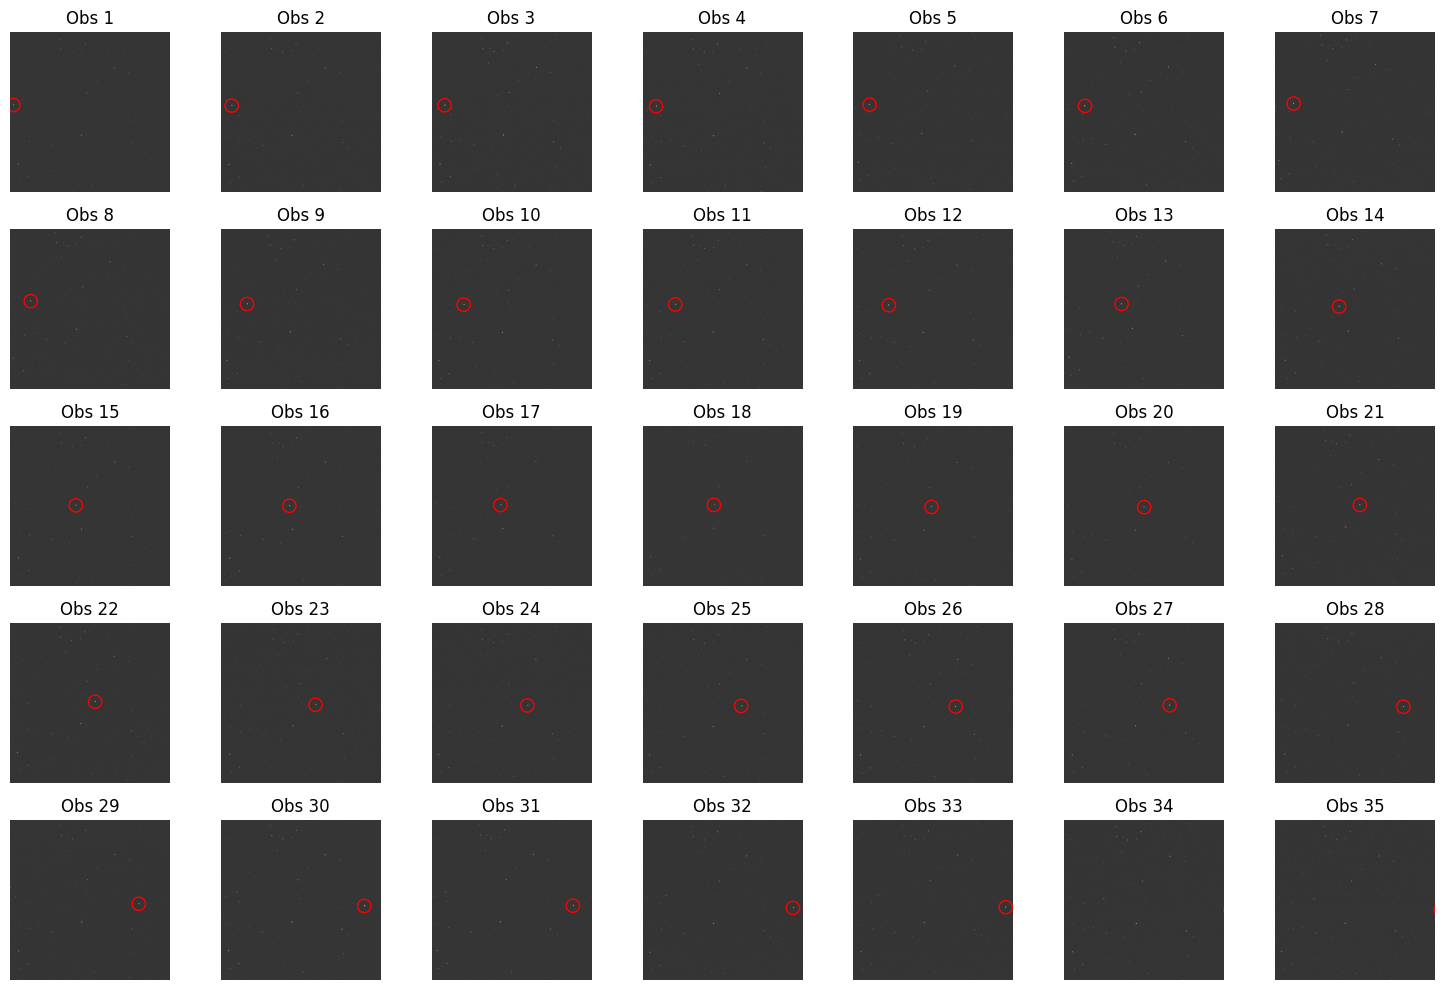

In [144]:

# tile plot images with asteroid positions marked
import matplotlib.pyplot as plt
import math

def imageprocessing(arr, min_clip=-100, max_clip=5000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

# 5 rows 7 cols
fig, axs = plt.subplots(5, 7, figsize=(15, 10))
axs = axs.flatten()
for idx, filename in enumerate(indices):
    hdulist = fits.open(filename)
    image_data = hdulist[1].data
    x, y = obs_data[filename]['pixel_coords']
    
    ax = axs[idx]
    ax.imshow(imageprocessing(image_data), cmap='gray', origin='lower')
    # ax.plot(x, y, 'ro', markersize=5)  # mark asteroid position
    #draw a large and thin circle on the position
    circle = plt.Circle((x, y), radius=100, color='red', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [145]:
#pop the last 2 indices
indices.pop()
indices.pop()

'2025-11-27-h12-m41-s15-ms437-ogg.fits'

In [146]:
len(indices)

33

# 3

In [147]:
   obs_data[indices[0]]['pixel_coords'][0]

51.463159313362894

In [161]:
# copying the same code from 3a-meanfererencestars-all.ipynb
# recall that obs_data[filename]['pixel_coords'] gives (x,y) of asteroid in that image is our estimate

import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
for idx, filename in enumerate(indices):
    print(f"Fitting Gaussians for file {idx+1} of {len(indices)}: {filename}")
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()
    #Gaussian2D model: amplitude, x_mean, y_mean, x_stddev, y_stddev, theta | None, cov_matrix | None
    # we'll just use the larger stdev and assume symmetric 2d gaussian later
    #using lmlsqfitter since we want a greedy fit since we're quite confident with initial guesses
    #x_mean and y_mean are the centroid positions, we already have good estimates
    
    # starting with an amplitude estimate
    # amplitude can be estimated as max pixel value in cutout - median pixel value in cutout
    # lets slice a 31 pixel cutout (+-15 pixels square) around each reference star centroid's rounded image x,y
    
    #within frame !!!!
    #array of 2d arrays, given by +- 15 pixels from center, where center is rounded x,y from merged_data
    #1 per reference star
    offset = 15
    
    x0 = obs_data[filename]['pixel_coords'][0]
    y0 = obs_data[filename]['pixel_coords'][1]
    cutout = pixel_array[round(y0)-offset:round(y0)+offset+1, round(x0)-offset:round(x0)+offset+1]

    amp_guess = np.max(cutout) #- np.median(cutout)
    
    # sigma visually looks like 2
    # x_fit 
    # y_fit 
    # sigma_fit
    
    #perform fit 
    x0_guess = offset  # since cutout is centered around star, x0 and y0 are at center of cutout
    y0_guess = offset
    sigma_guess = 5
    
    gauss_init = models.Gaussian2D(amplitude=amp_guess,
                                    x_mean=x0_guess,
                                    y_mean=y0_guess,
                                    x_stddev=sigma_guess,
                                    y_stddev=sigma_guess)
    
    fit_p = fitting.LevMarLSQFitter()
    y_indices, x_indices = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]   
    gauss_fit = fit_p(gauss_init, x_indices, y_indices, cutout)
    
    # since the fits are on a cutout, the image adjustment is: fit + rounded original center - offset
    x_fit = (gauss_fit.x_mean.value + round(x0) - offset)
    y_fit = (gauss_fit.y_mean.value + round(y0) - offset)
    sigma_fit = (gauss_fit.x_stddev.value + gauss_fit.y_stddev.value) / 2.0
        
    obs_data[filename]['ast_fit'] = {
        'xs_fit': x_fit,
        'ys_fit': y_fit,
        'sigmas_fit': sigma_fit
    }

Fitting Gaussians for file 1 of 33: 2025-11-25-h02-m00-s14-ms936-tfn.fits
Fitting Gaussians for file 2 of 33: 2025-11-25-h05-m00-s13-ms688-lsc.fits
Fitting Gaussians for file 3 of 33: 2025-11-25-h05-m36-s42-ms454-lsc.fits
Fitting Gaussians for file 4 of 33: 2025-11-25-h06-m06-s14-ms909-lsc.fits
Fitting Gaussians for file 5 of 33: 2025-11-25-h07-m45-s12-ms840-elp.fits
Fitting Gaussians for file 6 of 33: 2025-11-25-h08-m30-s09-ms718-elp.fits
Fitting Gaussians for file 7 of 33: 2025-11-25-h09-m06-s12-ms841-elp.fits
Fitting Gaussians for file 8 of 33: 2025-11-25-h10-m06-s14-ms367-elp.fits
Fitting Gaussians for file 9 of 33: 2025-11-25-h11-m06-s18-ms072-elp.fits
Fitting Gaussians for file 10 of 33: 2025-11-25-h12-m47-s39-ms526-ogg.fits
Fitting Gaussians for file 11 of 33: 2025-11-25-h13-m06-s13-ms287-ogg.fits
Fitting Gaussians for file 12 of 33: 2025-11-25-h14-m06-s15-ms196-ogg.fits
Fitting Gaussians for file 13 of 33: 2025-11-25-h23-m02-s40-ms929-tfn.fits
Fitting Gaussians for file 14 of 3

## Double check with image

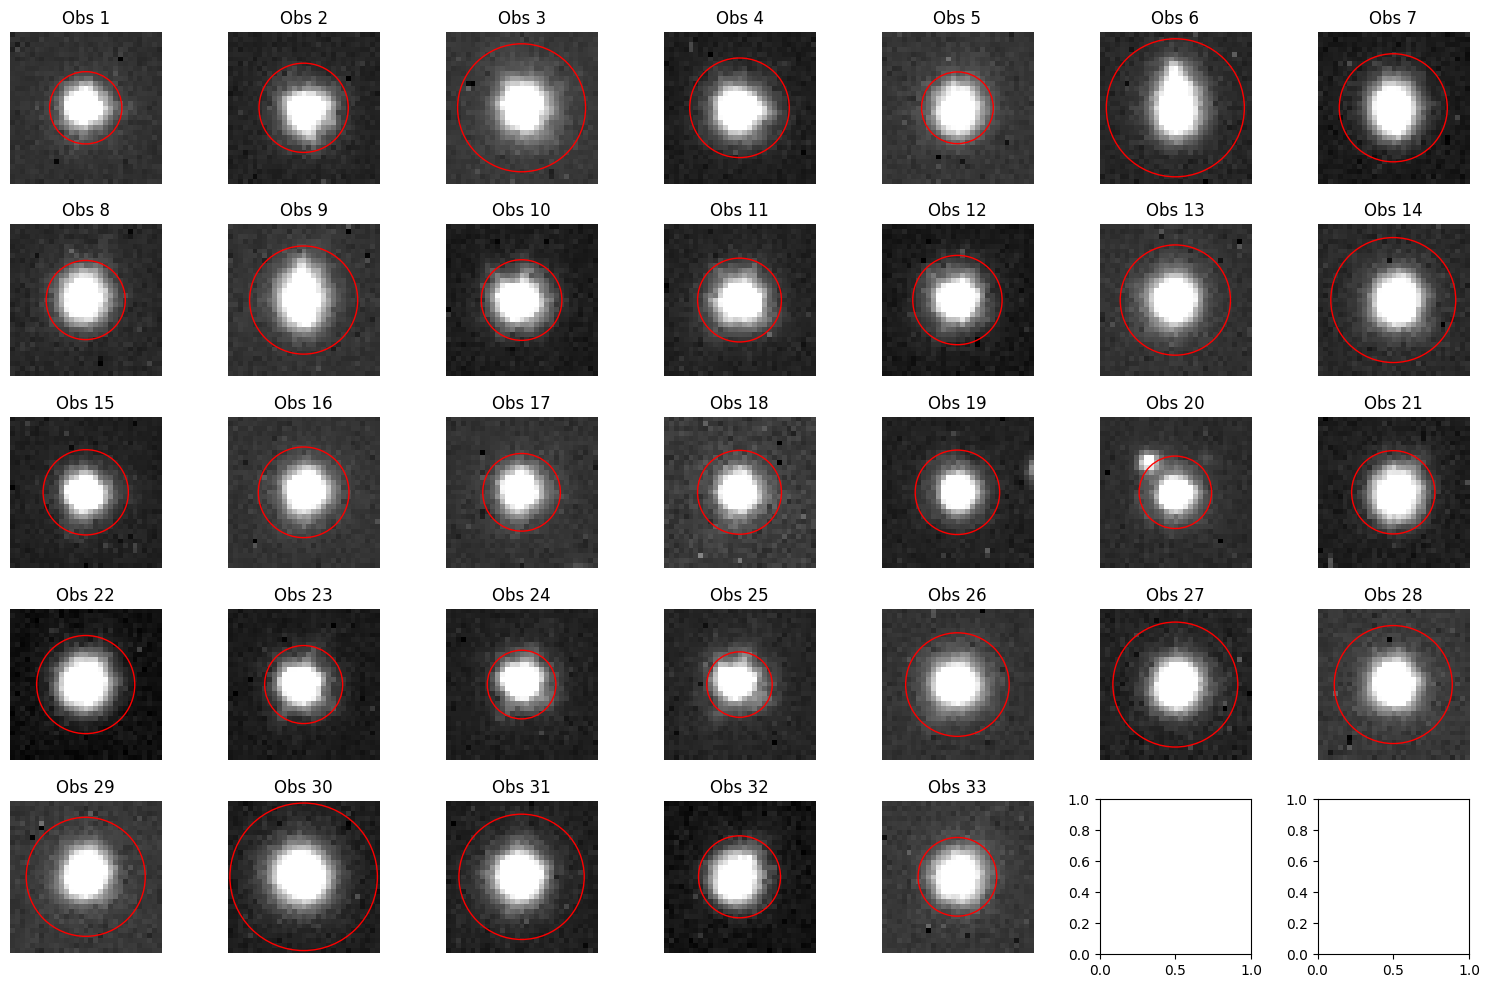

In [169]:
# tile plot images with asteroid positions marked
import matplotlib.pyplot as plt
import math

def imageprocessing(arr, min_clip=-100, max_clip=5000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

# 5 rows 7 cols
fig, axs = plt.subplots(5, 7, figsize=(15, 10))
axs = axs.flatten()
for idx, filename in enumerate(indices):
    hdulist = fits.open(filename)
    image_data = hdulist[1].data
    x, y = obs_data[filename]['ast_fit']['xs_fit'], obs_data[filename]['ast_fit']['ys_fit']
    sigma_fit = obs_data[filename]['ast_fit']['sigmas_fit']
    
    #cutout 15 pixels around
    offset = 15
    cutout = image_data[round(y)-offset:round(y)+offset+1, round(x)-offset:round(x)+offset+1]
    ax = axs[idx]
    #bringing in the normalization factor
    ax.imshow(imageprocessing(cutout / normcoeff_df[filename]), cmap='gray', origin='lower')
    # ax.plot(x, y, 'ro', markersize=5)  # mark asteroid position
    #draw a large and thin circle on the position
    circle = plt.Circle((offset, offset), radius=7*sigma_fit, color='red', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

there will be some issue with the aperture photometry on observation 20, so we'll eject that one as well

idx 19

In [170]:
# pop indx 19
indices.pop(19)

'2025-11-26-h06-m06-s06-ms084-lsc.fits'

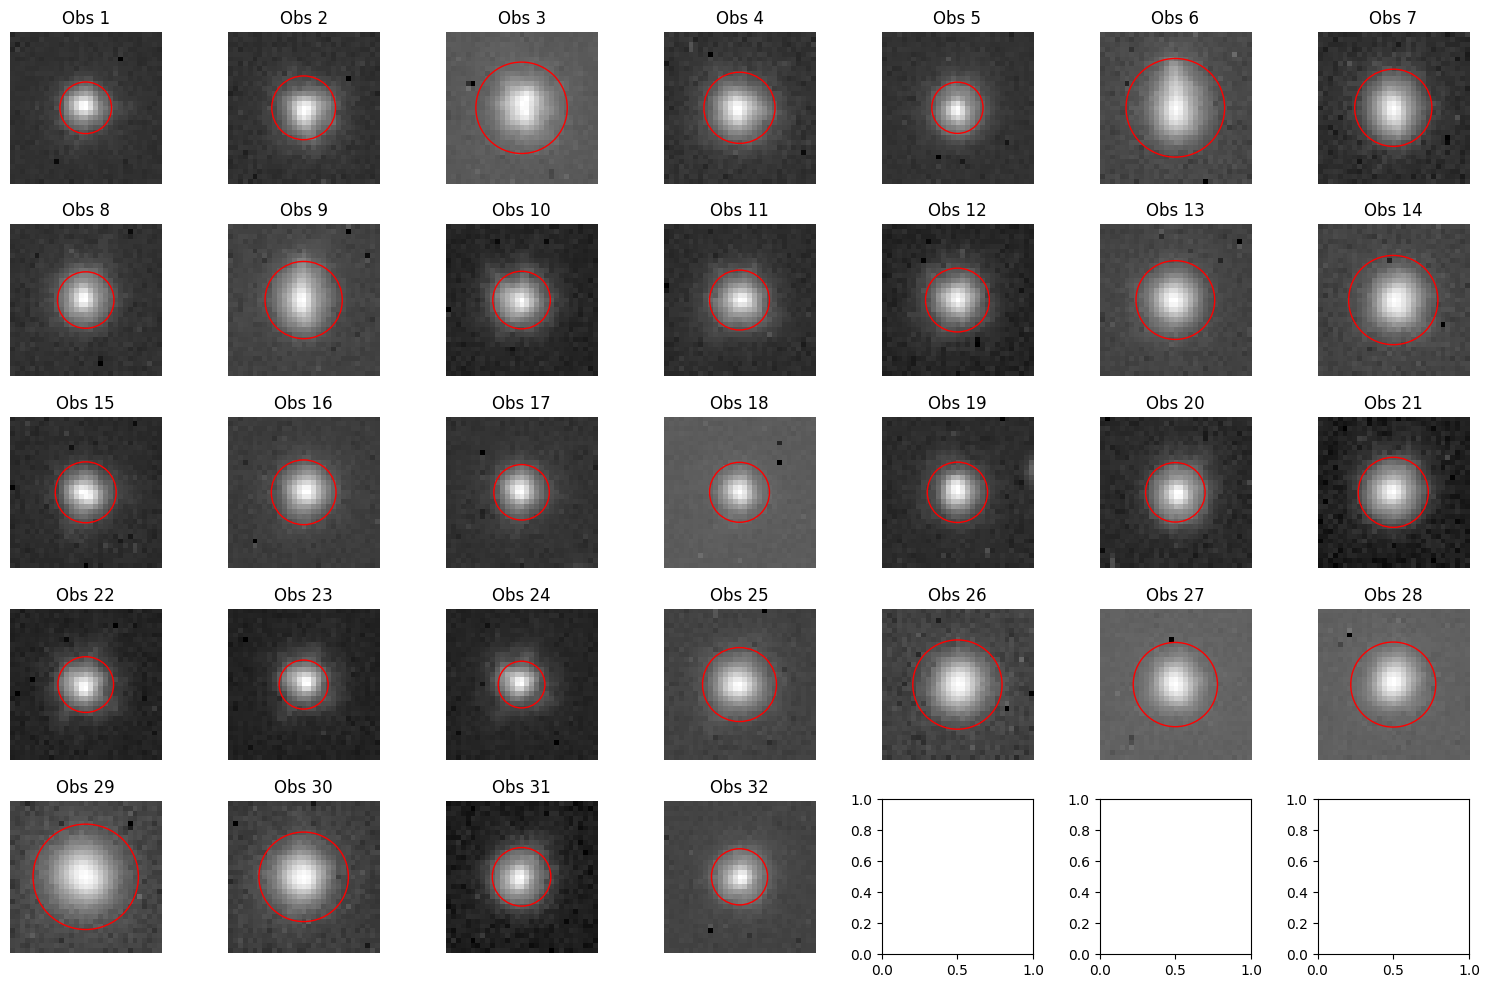

In [203]:
# tile plot images with asteroid positions marked
import matplotlib.pyplot as plt
import math

def imageprocessing(arr, a=1000, contrast=1, bias=0.5):
    min_im, max_im = np.min(arr), np.max(arr)
    norm = (arr - min_im) / (max_im - min_im)
    log = np.log(1 + a*norm) / np.log(1+a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

# 5 rows 7 cols
fig, axs = plt.subplots(5, 7, figsize=(15, 10))
axs = axs.flatten()
for idx, filename in enumerate(indices):
    hdulist = fits.open(filename)
    image_data = hdulist[1].data
    x, y = obs_data[filename]['ast_fit']['xs_fit'], obs_data[filename]['ast_fit']['ys_fit']
    sigma_fit = obs_data[filename]['ast_fit']['sigmas_fit']
    
    #cutout 15 pixels around
    offset = 15
    cutout = image_data[round(y)-offset:round(y)+offset+1, round(x)-offset:round(x)+offset+1]
    ax = axs[idx]
    #bringing in the normalization factor
    ax.imshow(imageprocessing(cutout / normcoeff_df[filename]), cmap='gray', origin='lower')
    # ax.plot(x, y, 'ro', markersize=5)  # mark asteroid position
    #draw a large and thin circle on the position
    circle = plt.Circle((offset, offset), radius=5*sigma_fit, color='red', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

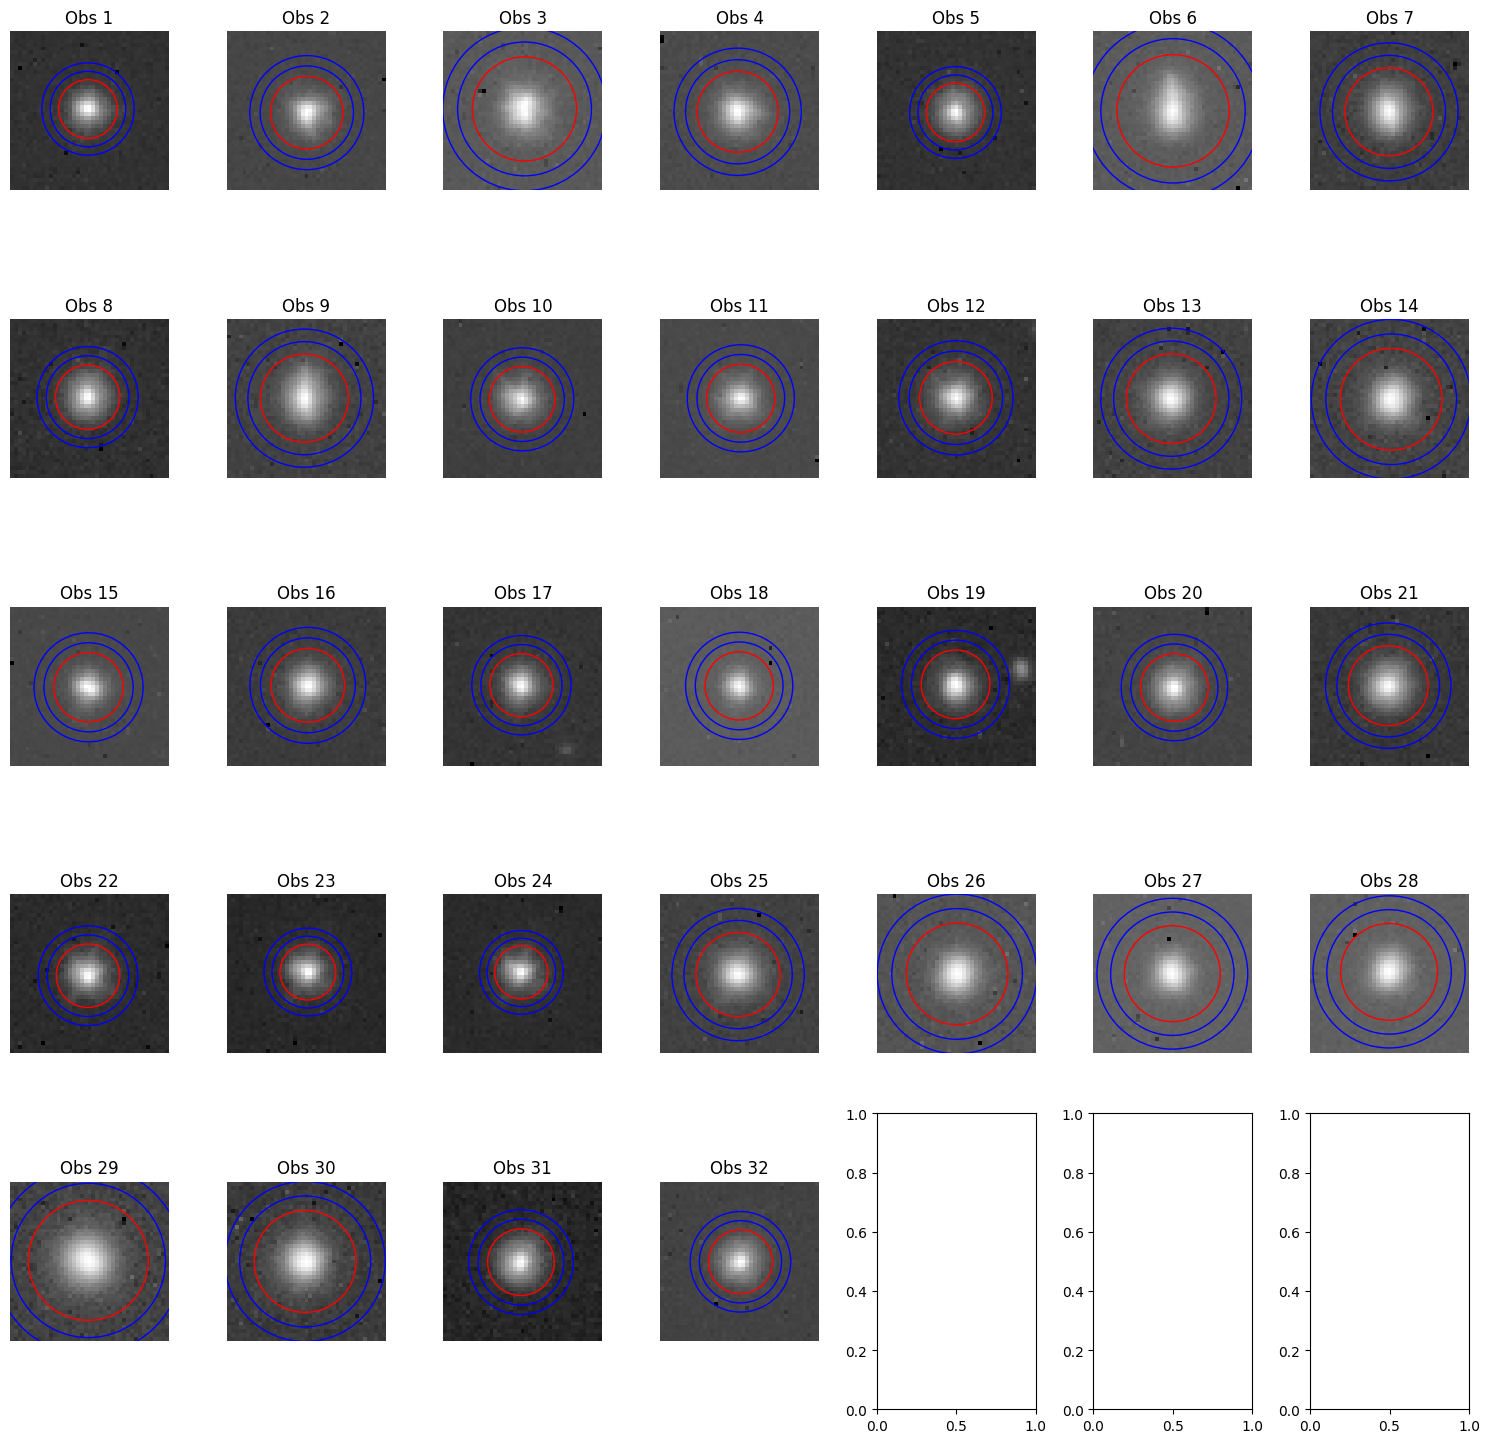

In [ ]:
#copied code again
from photutils.aperture import CircularAperture, CircularAnnulus
positions = [(x, y) for x,y in zip(
    [obs_data[file]['ast_fit']['xs_fit'] for file in indices],
    [obs_data[file]['ast_fit']['ys_fit'] for file in indices]
)]
sigmas = [obs_data[file]['ast_fit']['sigmas_fit'] for file in indices]
apertures = [CircularAperture(pos, r=7*sigma) for pos, sigma in zip(positions, sigmas)]
annulus_apertures = [CircularAnnulus(pos, r_in=9*sigma, r_out=11*sigma) for pos, sigma in zip(positions, sigmas)]


fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(15,15))
#draw image and overplot apertures and annuli
for idx, filename in enumerate(indices):
    print(f"Processing file {idx+1} of {len(indices)}: {filename}")
    ax = axes.flatten()[idx]
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()
    offset = 20
    cutout = pixel_array[round(positions[idx][1])-offset:round(positions[idx][1])+offset+1,
                         round(positions[idx][0])-offset:round(positions[idx][0])+offset+1]
    sigma_fit = sigmas[idx]
    ax.imshow(imageprocessing(cutout / normcoeff_df[filename]), cmap='gray', origin='lower',
              extent=(round(positions[idx][0])-offset,
                      round(positions[idx][0])+offset,
                      round(positions[idx][1])-offset,
                      round(positions[idx][1])+offset))
    apertures[idx].plot(ax=ax, color='red', lw=1)
    annulus_apertures[idx].plot(ax=ax, color='blue', lw=1)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [209]:
def get_pixelarray(filename):
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()
    return pixel_array

In [213]:
from astropy.stats import SigmaClip
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats

sigclip = SigmaClip(sigma=3.0, maxiters=10)

aper_stats_list = [ApertureStats(get_pixelarray(indices[idx]), aperture=ap, sigma_clip=None) 
                    for idx, ap in enumerate(apertures)]

annulus_stats_list = [ApertureStats(get_pixelarray(indices[idx]), aperture=ann_ap, sigma_clip=sigclip) 
                        for idx, ann_ap in enumerate(annulus_apertures)]
total_anulus_list = [annulus_stats.median * aper_stats.sum_aper_area.value for annulus_stats, aper_stats in zip(annulus_stats_list, aper_stats_list)]

apersum_subanulus_list  = [aper_stats.sum - total_anulus 
                            for aper_stats, total_anulus in zip(aper_stats_list, total_anulus_list)]

apersum_subanulus_list 

[np.float64(102026.91001858118),
 np.float64(105097.76592560146),
 np.float64(102887.77283631146),
 np.float64(105310.62341076098),
 np.float64(90760.66088273008),
 np.float64(91222.38222692609),
 np.float64(93921.4311873342),
 np.float64(89885.49919294192),
 np.float64(92966.74429264035),
 np.float64(103783.72279733965),
 np.float64(106149.35206821434),
 np.float64(103115.8430596268),
 np.float64(97180.69691181587),
 np.float64(92106.52470693912),
 np.float64(104861.84395608834),
 np.float64(108427.83203624742),
 np.float64(96890.96575467648),
 np.float64(52108.99152018661),
 np.float64(104962.15159492564),
 np.float64(99139.18915413652),
 np.float64(100576.78748107237),
 np.float64(111006.71030399998),
 np.float64(117508.13996667352),
 np.float64(108890.51734302615),
 np.float64(106055.22871683173),
 np.float64(80912.50049858571),
 np.float64(79837.23863595488),
 np.float64(79767.71788354187),
 np.float64(106739.2223751055),
 np.float64(108153.41696294246),
 np.float64(96971.86541977

In [246]:
for idx, filename in enumerate(indices):
    obs_data[filename]['ast_flux'] = apersum_subanulus_list[idx]
    obs_data[filename]['ast_flux_adjusted'] = apersum_subanulus_list[idx] / normcoeff_df[filename]

In [217]:
obs_data

{'2025-11-25-h02-m00-s14-ms936-tfn.fits': {'datetime': '2025-Nov-25 02:00:14.936',
  'observatory_code': 'Z31',
  'pixel_coords': (51.463159313362894, 1306.5623972735461),
  'ast_fit': {'xs_fit': np.float64(51.62072989929109),
   'ys_fit': np.float64(1307.466977084305),
   'sigmas_fit': np.float64(1.0564383007836518)},
  'ast_flux': np.float64(101343.42123106268)},
 '2025-11-25-h05-m00-s13-ms688-lsc.fits': {'datetime': '2025-Nov-25 05:00:13.688',
  'observatory_code': 'W85',
  'pixel_coords': (163.32838677069026, 1298.0649641231462),
  'ast_fit': {'xs_fit': np.float64(163.17460797988227),
   'ys_fit': np.float64(1298.5679769894073),
   'sigmas_fit': np.float64(1.304471753837171)},
  'ast_flux': np.float64(99306.21987550607)},
 '2025-11-25-h05-m36-s42-ms454-lsc.fits': {'datetime': '2025-Nov-25 05:36:42.454',
  'observatory_code': 'W85',
  'pixel_coords': (193.39110815730476, 1302.7177748840788),
  'ast_fit': {'xs_fit': np.float64(193.42991349749983),
   'ys_fit': np.float64(1303.4952267

In [247]:
#plot the fluxes vs time
import matplotlib.pyplot as plt

times = []
fluxes = []
fluxes_adjusted = []
for filename in indices:
    times.append(obs_data[filename]['datetime'])
    fluxes.append(obs_data[filename]['ast_flux'])
    fluxes_adjusted.append(obs_data[filename]['ast_flux_adjusted'])
    
#times[0]
#2025-Nov-25 02:00:14.936

#need to convert to a continuous time format for plotting
import pandas as pd
time_nums = pd.to_datetime(times)
time_nums

DatetimeIndex(['2025-11-25 02:00:14.936000', '2025-11-25 05:00:13.688000',
               '2025-11-25 05:36:42.454000', '2025-11-25 06:06:14.909000',
               '2025-11-25 07:45:12.840000', '2025-11-25 08:30:09.718000',
               '2025-11-25 09:06:12.841000', '2025-11-25 10:06:14.367000',
               '2025-11-25 11:06:18.072000', '2025-11-25 12:47:39.526000',
               '2025-11-25 13:06:13.287000', '2025-11-25 14:06:15.196000',
               '2025-11-25 23:02:40.929000', '2025-11-25 23:35:17.210000',
               '2025-11-26 00:55:17.907000', '2025-11-26 01:55:17.940000',
               '2025-11-26 02:10:07.425000', '2025-11-26 03:06:19.581000',
               '2025-11-26 05:35:14.393000', '2025-11-26 07:59:44.591000',
               '2025-11-26 08:06:06.512000', '2025-11-26 11:06:14.445000',
               '2025-11-26 12:06:12.274000', '2025-11-26 13:06:14.392000',
               '2025-11-26 14:06:13.681000', '2025-11-26 15:14:48.233000',
               '2025-11-2

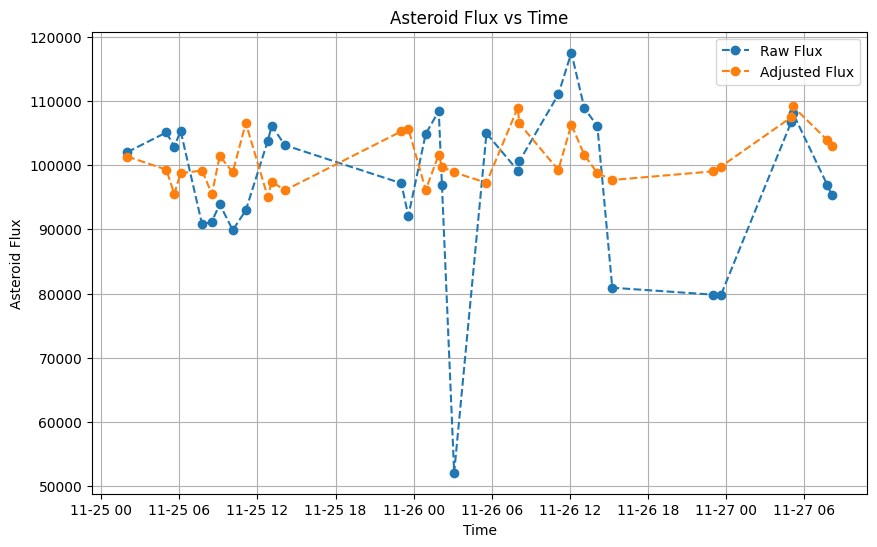

In [258]:
#plot
plt.figure(figsize=(10,6))
plt.plot(time_nums, fluxes, marker='o', linestyle='--', label='Raw Flux')
plt.plot(time_nums, fluxes_adjusted, marker='o', linestyle='--', label='Adjusted Flux')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Asteroid Flux')
plt.title('Asteroid Flux vs Time')
plt.grid(True)
plt.show()

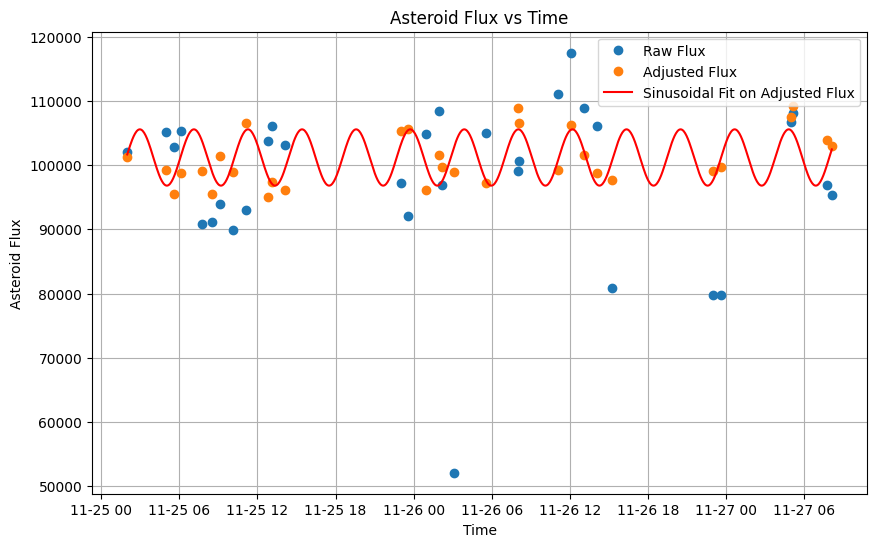

Guess Parameters:
Amplitude Guess: 7067.764411500459
Period Guess: 4.0 hours
Mean Guess: 99531.58763006485

Fitted Parameters:
Fitted Amplitude: 4381.075473925626
Fitted Period: 4.152225655780184 hours
Fitted Phase: 0.1090464198772958 radians
Fitted Mean: 101195.28348766023

Fitted Parameter Standard Squares:
Amplitude Variance: 536700.1848935855
Period Variance: 1.1384363234630989e-06
Phase Variance: 0.07990452063878482
Mean Variance: 287402.54887378373


In [276]:
# run a sinusoidal fit to the data: y_ij ~ A sin(2 pi f t_i + phi) + mu
from scipy.optimize import curve_fit
def sinusoidal(t, A, T, phi, mu):
    return A * np.sin(2 * np.pi * t / T + phi) + mu

#convert time_nums to numerical values in days since first observation
time_nums_days = (time_nums - time_nums[0]).total_seconds() / 86400.0

#fit
amplitude_guess = (max(fluxes_adjusted)-min(fluxes_adjusted))/2
mean_guess = np.median(fluxes_adjusted)
period_days_guess = 4.0 / 24  # 4 hours in days

popt, pcov = curve_fit(sinusoidal, time_nums_days, fluxes_adjusted, p0=[amplitude_guess, period_days_guess, 0.0, mean_guess])

A_fit, T_fit, phi_fit, mu_fit = popt
A_fit, T_fit, phi_fit, mu_fit
#plot the fit

plt.figure(figsize=(10,6))
plt.plot(time_nums, fluxes, marker='o', linestyle='', label='Raw Flux')
plt.plot(time_nums, fluxes_adjusted, marker='o', linestyle='', label='Adjusted Flux')
t_fit = np.linspace(min(time_nums_days), max(time_nums_days), 1000)
flux_fit = sinusoidal(t_fit, *popt)
plt.plot(time_nums[0] + pd.to_timedelta(t_fit, unit='D'), flux_fit, 'r-', label='Sinusoidal Fit on Adjusted Flux')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Asteroid Flux')
plt.title('Asteroid Flux vs Time')
plt.grid(True)
plt.show()

print("Guess Parameters:")
print(f"Amplitude Guess: {amplitude_guess}")
print(f"Period Guess: {24*period_days_guess} hours")
print(f"Mean Guess: {mean_guess}")

#show fit parameters
print("\nFitted Parameters:")
print(f"Fitted Amplitude: {A_fit}")
print(f"Fitted Period: {24*T_fit} hours")
print(f"Fitted Phase: {phi_fit} radians")
print(f"Fitted Mean: {mu_fit}")

#get variance of parameters from covariance matrix
perr = np.diag(pcov)
print("\nFitted Parameter Standard Squares:")
print(f"Amplitude Variance: {perr[0]}")
print(f"Period Variance: {perr[1]}")
print(f"Phase Variance: {perr[2]}")
print(f"Mean Variance: {perr[3]}")

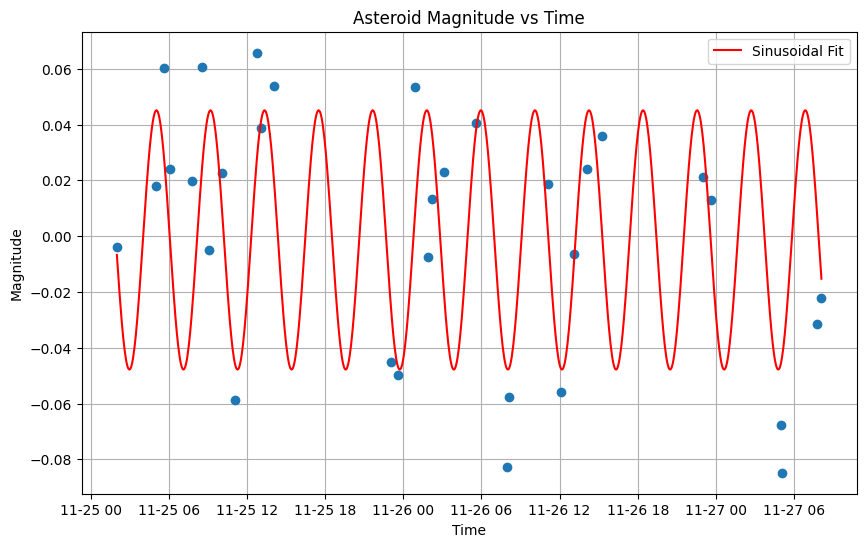

Fitted Amplitude (mag): -0.04646667253126692
Fitted Period (mag): 4.1519189430153265 hours
Fitted Phase (mag): 0.11610893382763403 radians
Fitted Mean (mag): -0.0013498459748918043


In [278]:
#transform the data:
#standard Relative magnitude formula: m = -2.5 log10(F/F0)
#we can set F0 = mean flux
mean_flux = np.mean(fluxes_adjusted)
magnitudes = -2.5 * np.log10(fluxes_adjusted / mean_flux)

#sinusoidal fit to magnitudes
popt_mag, pcov_mag = curve_fit(sinusoidal, time_nums_days, magnitudes, p0=[(max(magnitudes)-min(magnitudes))/2, 4/24, 0.0, 0])
A_fit_mag, T_fit_mag, phi_fit_mag, mu_fit_mag = popt_mag

#plot magnitudes vs time
plt.figure(figsize=(10,6))
plt.plot(time_nums, magnitudes, marker='o', linestyle='')
#plot the fit
t_fit = np.linspace(min(time_nums_days), max(time_nums_days), 1000)
mag_fit = sinusoidal(t_fit, *popt_mag)
plt.plot(time_nums[0] + pd.to_timedelta(t_fit, unit='D'), mag_fit, 'r-', label='Sinusoidal Fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Asteroid Magnitude vs Time')
plt.grid(True)
plt.show()

print(f"Fitted Amplitude (mag): {A_fit_mag}")
print(f"Fitted Period (mag): {24*T_fit_mag} hours")
print(f"Fitted Phase (mag): {phi_fit_mag} radians")
print(f"Fitted Mean (mag): {mu_fit_mag}")